In [1]:
from sympy.physics.mechanics import *
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from json import dump
from subprocess import call

In [2]:
def make_func(config, val_type, method):
    m1, m2, l1, l2, g = sp.symbols('m1 m2 l1 l2 g')
    q1, q2 = dynamicsymbols('s[0] s[1]')
    q1d, q2d = dynamicsymbols('s[0] s[1]', 1)
    v1, v2 = dynamicsymbols('s[2] s[3]')
    L = (m1 + m2)/2 * l1**2 * q1d**2 + m2/2 * l2**2 * q2**2 + m2*l1*l2*q1d*q2d*sp.cos(q1-q2) + (m1 + m2)*g*l1*sp.cos(q1) + m2*g*l2*sp.cos(q2)
    LM = LagrangesMethod(L, [q1, q2])
    LM.form_lagranges_equations()
    out = open('function.cpp', 'w')
    print('#include <valarray>', file=out)
    print('#include <string>', file=out)
    print('#include "function.h"', file=out)
    print('using namespace std;', file=out)
    print('#undef ValType', file=out)
    print('#define ValType '+val_type, file=out)
    print('#undef METHOD', file=out)
    print('#define METHOD (std::string)"'+ method +'"', file=out)
    print('valarray<ValType> F(ValType t, valarray<ValType> s) {', file=out)
    print('\treturn valarray<ValType> {s[2], s[3],', 
        str(LM.forcing[0].subs({
            q1d:v1,
            q2d:v2,
            l1:config['pars']['l1'],
            l2:config['pars']['l2'],
            m1:config['pars']['m1'],
            m2:config['pars']['m2'],
            g:config['pars']['g']})).replace('(t)', ''),
        ', ',
        str(LM.forcing[1].subs({
            q1d:v1,
            q2d:v2,
            l1:config['pars']['l1'],
            l2:config['pars']['l2'],
            m1:config['pars']['m1'],
            m2:config['pars']['m2'],
            g:config['pars']['g']})).replace('(t)', ''),
        '};',
        file=out)
    print('}', file=out)
    out.close()

In [3]:
def make_json(config):
    out = open('config.json', 'w')
    dump({
        'init' : [
            config['init']['q1'],
            config['init']['q2'],
            config['init']['v1'],
            config['init']['v2']
        ],
        'modeling' : {
            'time' : config['modeling']['time'],
            'dt': config['modeling']['dt'],
            'steps' : config['modeling']['steps']
        }
    }, out, indent=4)
    out.close()

In [4]:
def get_data(config, val_type = 'double', method = 'rk45'):
    make_func(config, val_type, method)
    make_json(config)
    call('make')
    call('main.exe')
    d =  pd.DataFrame(np.fromfile('output.binary', dtype=np.dtype([
    ('q1', np.float64), 
    ('q2', np.float64), 
    ('v1', np.float64),
    ('v2', np.float64)
    ])))
    call('make clean')
    return d

In [14]:
d = get_data({
    'init' : {
        'q1' : np.pi/2 - .5,
        'q2' : .5,
        'v1' : 0,
        'v2' : 0
    },
    'pars' : {
        'm1' : 1,
        'm2' : 2,
        'l1' : 3,
        'l2' : 4,
        'g' : 9.81
    },
    'modeling' : {
        'time' : 200,
        "dt": .01,
        "steps" : 1
    }
})

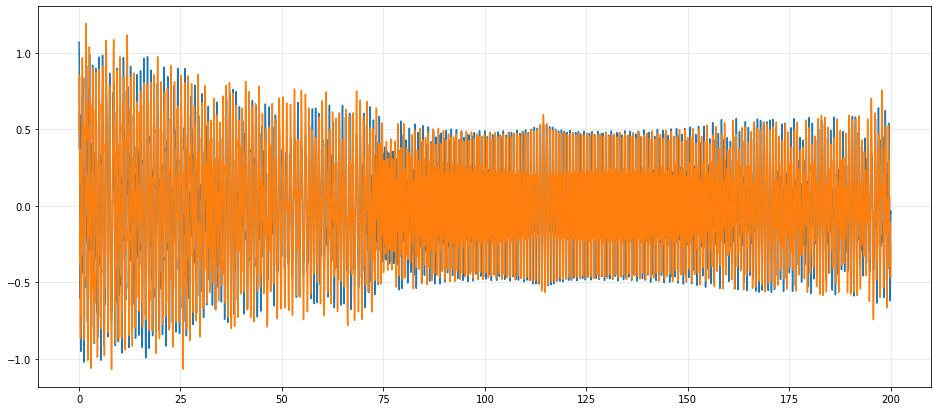

In [15]:
fig, ax = plt.subplots()
fig.set_size_inches(16,7)

t = np.linspace(0, len(d)*.01, len(d))
ax.plot(t, d.q1)
ax.plot(t, d.q2)

ax.grid(True, alpha=.3)
plt.show()